<a href="https://colab.research.google.com/github/mahsaa99/crypto-volatility-/blob/main/Garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install yfinance pandas numpy matplotlib scipy statsmodels arch seaborn scikit-learn ace_tools

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from datetime import timedelta
from scipy.stats import ttest_1samp
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.9 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd

# Load data with explicit date format (MM/DD/YY)
btc_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Btc dailz till november.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'  # Replacing deprecated date_parser
)
btc_data = btc_data.sort_index()  # Ensure data is sorted by Date

eth_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/ETH daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
eth_data = eth_data.sort_index()

sp500_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Spx daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
sp500_data = sp500_data.sort_index()

vix_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Vix daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
vix_data = vix_data.sort_index()

gold_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/gold daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
gold_data = gold_data.sort_index()

oil_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/oil daily.csv',
    parse_dates=['Date'],
    index_col='Date',
    date_format='%m/%d/%y'
)
oil_data = oil_data.sort_index()

# Restrict the time span to 01.2018–09.2024
btc_data = btc_data.loc['2017-01-01':'2024-09-30']
eth_data = eth_data.loc['2017-01-01':'2024-09-30']
sp500_data = sp500_data.loc['2017-01-01':'2024-09-30']
vix_data = vix_data.loc['2017-01-01':'2024-09-30']
gold_data = gold_data.loc['2017-01-01':'2024-09-30']
oil_data = oil_data.loc['2017-01-01':'2024-09-30']

print("Data loaded, dates parsed correctly, and filtered for the specified time span.")


Data loaded, dates parsed correctly, and filtered for the specified time span.


In [ ]:
def calculate_returns(data, price_column):
    data = data.copy()
    data['Return'] = data[price_column].pct_change()
    # Drop rows with NaN values
    data = data.dropna()
    return data[['Return']]

# Calculate daily returns for all datasets
btc_data = calculate_returns(btc_data, 'Close')
eth_data = calculate_returns(eth_data, 'Close')
sp500_data = calculate_returns(sp500_data, 'Close')
gold_data = calculate_returns(gold_data, 'Close')
oil_data = calculate_returns(oil_data, 'Close')
vix_data = vix_data[['Close']].rename(columns={'Close': 'VIX'})

# Align all datasets to common dates
common_dates = btc_data.index.intersection(eth_data.index).intersection(sp500_data.index)
common_dates = common_dates.intersection(gold_data.index).intersection(oil_data.index).intersection(vix_data.index)

btc_data = btc_data.loc[common_dates]
eth_data = eth_data.loc[common_dates]
sp500_data = sp500_data.loc[common_dates]
gold_data = gold_data.loc[common_dates]
oil_data = oil_data.loc[common_dates]
vix_data = vix_data.loc[common_dates]

# Combine data into a single DataFrame for analysis
returns_df = pd.concat([
    btc_data.rename(columns={'Return': 'BTC'}),
    eth_data.rename(columns={'Return': 'ETH'}),
    sp500_data.rename(columns={'Return': 'SP500'}),
    gold_data.rename(columns={'Return': 'Gold'}),
    oil_data.rename(columns={'Return': 'Oil'}),
    vix_data
], axis=1)

print(returns_df)



                 BTC       ETH     SP500      Gold       Oil    VIX
Date                                                               
2018-09-28 -0.007568 -0.033526 -0.000007  0.006806  0.015668  12.12
2018-10-01 -0.001713  0.003129  0.003641 -0.001587  0.027986  12.00
2018-10-02 -0.003933 -0.015660 -0.000397  0.012052 -0.000930  12.05
2018-10-03 -0.013165 -0.037846  0.000711 -0.004961  0.015685  11.61
2018-10-04  0.016712  0.022947 -0.008170  0.002146 -0.027222  14.22
...              ...       ...       ...       ...       ...    ...
2024-09-24  0.014367 -0.004084  0.002511  0.010796  0.016911  15.39
2024-09-25 -0.011495 -0.026626 -0.001861 -0.000079 -0.026132  15.41
2024-09-26  0.018745  0.019932  0.004039  0.005830 -0.028986  15.37
2024-09-27  0.017544  0.023773 -0.001253 -0.005291  0.007537  16.96
2024-09-30 -0.031123 -0.018013  0.004237 -0.008901 -0.000147  16.73

[1508 rows x 6 columns]


In [ ]:
# Descriptive statistics for each dataset
print("BTC Returns Summary:")
print(btc_data['Return'].describe())

print("ETH Returns Summary:")
print(eth_data['Return'].describe())

print("S&P 500 Returns Summary:")
print(sp500_data['Return'].describe())

print("Gold Returns Summary:")
print(gold_data['Return'].describe())

print("Oil Returns Summary:")
print(oil_data['Return'].describe())

print("VIX Returns Summary:")
print(vix_data.describe())

BTC Returns Summary:
count    1508.000000
mean        0.001538
std         0.036969
min        -0.271875
25%        -0.015437
50%         0.000225
75%         0.018871
max         0.171601
Name: Return, dtype: float64
ETH Returns Summary:
count    1508.000000
mean        0.001753
std         0.046572
min        -0.332859
25%        -0.020068
50%         0.000244
75%         0.023984
max         0.316664
Name: Return, dtype: float64
S&P 500 Returns Summary:
count    1508.000000
mean        0.000563
std         0.012934
min        -0.119841
25%        -0.004806
50%         0.000874
75%         0.007014
max         0.093828
Name: Return, dtype: float64
Gold Returns Summary:
count    1508.000000
mean        0.000535
std         0.009191
min        -0.056947
25%        -0.004394
50%         0.000747
75%         0.005575
max         0.050920
Name: Return, dtype: float64
Oil Returns Summary:
count    1508.000000
mean       -0.001962
std         0.091275
min        -3.059661
25%        -0.0134

In [ ]:
# Load the FOMC data and parse the correct date column
fed_data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/fomc rate descion final edition.csv',
    parse_dates=['Date Time'],  # Use 'Date Time' as the date column
    index_col=None,            # Ensure no column is set as the index yet
    low_memory=False           # Handle mixed types in large files
)

# Normalize the 'Date Time' column to extract only the date (remove time part)
fed_data['Date'] = pd.to_datetime(fed_data['Date Time']).dt.normalize()

# Display the first few rows to confirm
print(fed_data.head())


            Date Time                             Event Survey Actual  Prior  \
0 2018-01-31 20:00:00  FOMC Rate Decision (Upper Bound)  1.50%  1.50%  1.50%   
1 2018-01-31 20:00:00  FOMC Rate Decision (Lower Bound)  1.25%  1.25%  1.25%   
2 2018-03-21 19:00:00  FOMC Rate Decision (Upper Bound)  1.75%  1.75%  1.50%   
3 2018-03-21 19:00:00  FOMC Rate Decision (Lower Bound)  1.50%  1.50%  1.25%   
4 2018-05-02 20:00:00  FOMC Rate Decision (Upper Bound)  1.75%  1.75%  1.75%   

        Date  
0 2018-01-31  
1 2018-01-31  
2 2018-03-21  
3 2018-03-21  
4 2018-05-02  


In [ ]:
# Convert 'Survey', 'Actual', and 'Prior' to numeric, stripping '%' if present
fed_data['Actual'] = pd.to_numeric(fed_data['Actual'].astype(str).str.replace('%', ''), errors='coerce')
fed_data['Survey'] = pd.to_numeric(fed_data['Survey'].astype(str).str.replace('%', ''), errors='coerce')
fed_data['Prior'] = pd.to_numeric(fed_data['Prior'].astype(str).str.replace('%', ''), errors='coerce')

# Drop rows with invalid numeric values
fed_data = fed_data.dropna(subset=['Actual', 'Survey', 'Prior'])

print(f"Processed FOMC data:\n{fed_data.head()}")


Processed FOMC data:
            Date Time                             Event  Survey  Actual  \
0 2018-01-31 20:00:00  FOMC Rate Decision (Upper Bound)    1.50    1.50   
1 2018-01-31 20:00:00  FOMC Rate Decision (Lower Bound)    1.25    1.25   
2 2018-03-21 19:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   
3 2018-03-21 19:00:00  FOMC Rate Decision (Lower Bound)    1.50    1.50   
4 2018-05-02 20:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   

   Prior       Date  
0   1.50 2018-01-31  
1   1.25 2018-01-31  
2   1.50 2018-03-21  
3   1.25 2018-03-21  
4   1.75 2018-05-02  


In [ ]:
# Calculate 'Surprise' as the difference between 'Actual' and 'Survey'
fed_data['Surprise'] = fed_data['Actual'] - fed_data['Survey']

# Define categories: Hawkish, Dovish, and No Change
fed_data['Category'] = pd.cut(
    fed_data['Actual'] - fed_data['Prior'],
    bins=[-float('inf'), -1e-9, 1e-9, float('inf')],  # Small tolerance for floating point precision
    labels=['Dovish', 'Neutral', 'Hawkish']
)

# Display all categorized events
print("All Categorized Events (with No Change):")
print(fed_data[['Date', 'Actual', 'Survey', 'Prior', 'Surprise', 'Category']])


All Categorized Events (with No Change):
          Date  Actual  Survey  Prior  Surprise Category
0   2018-01-31    1.50    1.50   1.50      0.00  Neutral
2   2018-03-21    1.75    1.75   1.50      0.00  Hawkish
4   2018-05-02    1.75    1.75   1.75      0.00  Neutral
6   2018-06-13    2.00    2.00   1.75      0.00  Hawkish
8   2018-08-01    2.00    2.00   2.00      0.00  Neutral
10  2018-09-26    2.25    2.25   2.00      0.00  Hawkish
12  2018-11-08    2.25    2.25   2.25      0.00  Neutral
14  2018-12-19    2.50    2.50   2.25      0.00  Hawkish
16  2019-01-30    2.50    2.50   2.50      0.00  Neutral
18  2019-03-20    2.50    2.50   2.50      0.00  Neutral
20  2019-05-01    2.50    2.50   2.50      0.00  Neutral
22  2019-06-19    2.50    2.50   2.50      0.00  Neutral
24  2019-07-31    2.25    2.25   2.50      0.00   Dovish
26  2019-09-18    2.00    2.00   2.25      0.00   Dovish
28  2019-10-30    1.75    1.75   2.00      0.00   Dovish
30  2019-12-11    1.75    1.75   1.75      0.00

In [ ]:
# Remove rows with duplicated dates (keeping the first occurrence)
fed_data = fed_data.drop_duplicates(subset=['Date'], keep='first')

# Verify that duplicates are removed
print(f"Data after removing duplicates (based on Date): {fed_data.shape}")
print(fed_data.head())


Data after removing duplicates (based on Date): (54, 8)
            Date Time                             Event  Survey  Actual  \
0 2018-01-31 20:00:00  FOMC Rate Decision (Upper Bound)    1.50    1.50   
2 2018-03-21 19:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   
4 2018-05-02 20:00:00  FOMC Rate Decision (Upper Bound)    1.75    1.75   
6 2018-06-13 20:00:00  FOMC Rate Decision (Upper Bound)    2.00    2.00   
8 2018-08-01 20:00:00  FOMC Rate Decision (Upper Bound)    2.00    2.00   

   Prior       Date  Surprise Category  
0   1.50 2018-01-31       0.0  Neutral  
2   1.50 2018-03-21       0.0  Hawkish  
4   1.75 2018-05-02       0.0  Neutral  
6   1.75 2018-06-13       0.0  Hawkish  
8   2.00 2018-08-01       0.0  Neutral  


In [ ]:
# Add FOMC-related variables to the main dataset
returns_df['Announcement'] = returns_df.index.isin(fed_data['Date']).astype(int)

# Map surprise values and categories from FOMC data into the main dataset
returns_df['Surprise'] = returns_df.index.map(
    lambda x: fed_data.loc[fed_data['Date'] == x, 'Surprise'].values[0] if x in fed_data['Date'].values else 0
)
returns_df['Category'] = returns_df.index.map(
    lambda x: fed_data.loc[fed_data['Date'] == x, 'Category'].values[0] if x in fed_data['Date'].values else 'None'
)


# Verify the final combined DataFrame
print("Combined DataFrame for Analysis:")
print(returns_df.head())


Combined DataFrame for Analysis:
                 BTC       ETH     SP500      Gold       Oil    VIX  \
Date                                                                  
2018-10-03 -0.013165 -0.037846  0.000711 -0.004961  0.015685  11.61   
2018-10-04  0.016712  0.022947 -0.008170  0.002146 -0.027222  14.22   
2018-10-05 -0.001065  0.000441 -0.005528  0.003092  0.000135  14.82   
2018-10-08  0.013832  0.027788 -0.000395 -0.012919 -0.000673  15.69   
2018-10-09 -0.006520 -0.011888 -0.001418  0.001422  0.009019  15.95   

            Announcement  Surprise Category  COVID  BTC_Lagged  ETH_Lagged  
Date                                                                        
2018-10-03             0       0.0     None      0   -0.003933   -0.015660  
2018-10-04             0       0.0     None      0   -0.013165   -0.037846  
2018-10-05             0       0.0     None      0    0.016712    0.022947  
2018-10-08             0       0.0     None      0   -0.001065    0.000441  
2018-10

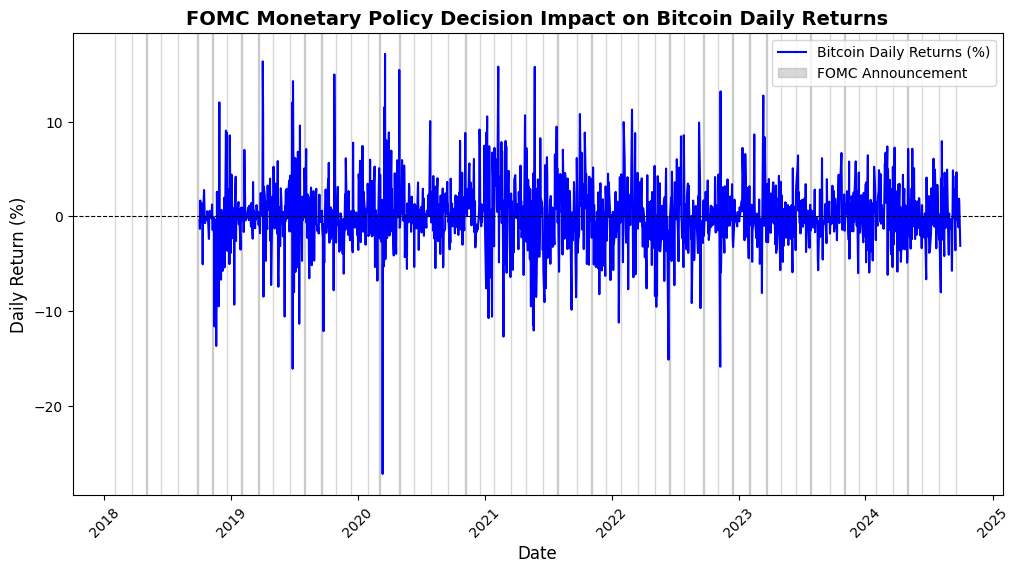

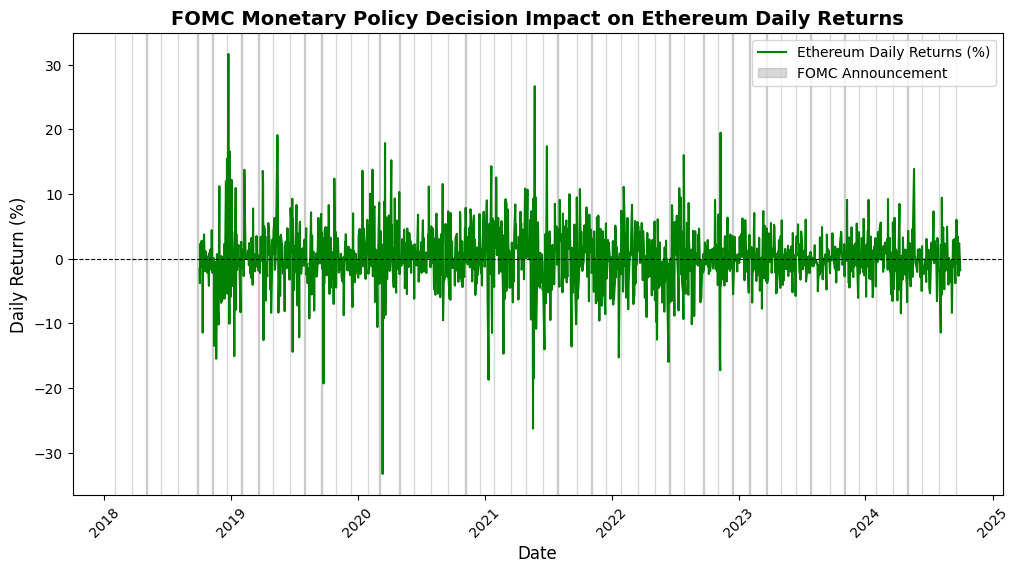

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure FOMC announcement dates are in datetime format and remove duplicates
fed_data["Date"] = pd.to_datetime(fed_data["Date"]).drop_duplicates()

# Create figure for Bitcoin
fig, ax = plt.subplots(figsize=(12, 6))

# Plot BTC Daily Returns
ax.plot(returns_df.index, returns_df["BTC"] * 100, color="blue", linewidth=1.5, label="Bitcoin Daily Returns (%)")

# Overlay shaded regions for FOMC announcements
for i, date in enumerate(fed_data["Date"]):
    ax.axvspan(date, date + pd.Timedelta(days=1), color="gray", alpha=0.3,
               label="FOMC Announcement" if i == 0 else "")

# Labels and Formatting
ax.set_title("FOMC Monetary Policy Decision Impact on Bitcoin Daily Returns", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Daily Return (%)", fontsize=12)
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # Zero-return reference line
ax.legend(loc="upper right")
ax.grid(False)

# Improve X-axis readability
plt.xticks(rotation=45)
plt.show()


# Create figure for Ethereum
fig, ax = plt.subplots(figsize=(12, 6))

# Plot ETH Daily Returns
ax.plot(returns_df.index, returns_df["ETH"] * 100, color="green", linewidth=1.5, label="Ethereum Daily Returns (%)")

# Overlay shaded regions for FOMC announcements
for i, date in enumerate(fed_data["Date"]):
    ax.axvspan(date, date + pd.Timedelta(days=1), color="gray", alpha=0.3,
               label="FOMC Announcement" if i == 0 else "")

# Labels and Formatting
ax.set_title("FOMC Monetary Policy Decision Impact on Ethereum Daily Returns", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Daily Return (%)", fontsize=12)
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # Zero-return reference line
ax.legend(loc="upper right")
ax.grid(False)

# Improve X-axis readability
plt.xticks(rotation=45)
plt.show()


In [ ]:
import statsmodels.api as sm
from arch import arch_model

# Create lagged return variables for both BTC and ETH
returns_df["BTC_Lagged"] = returns_df["BTC"].shift(1)
returns_df["ETH_Lagged"] = returns_df["ETH"].shift(1)

# Drop NaN values caused by the lag
returns_df = returns_df.dropna()

# Define independent variables (Mean Equation)
independent_vars = [
    "SP500",  # Stock market index
    "Gold",   # Gold price changes
    "Oil",    # Crude oil price changes
    "VIX",    # Market volatility index
    "Announcement",  # FOMC event dummy (1 on announcement days, 0 otherwise)
    "Surprise",      # Interest rate surprise component
]

# Function to fit OLS and GARCH(1,1) for both BTC and ETH
def run_ols_garch(asset):
    print(f"\n\n********** {asset} Model **********")

    # Add the lagged return of the specific asset
    independent_vars_with_lag = [f"{asset}_Lagged"] + independent_vars

    # Prepare the OLS model
    X = returns_df[independent_vars_with_lag]
    X = sm.add_constant(X)  # Add intercept term
    y = returns_df[asset]

    # Fit OLS Model
    ols_model = sm.OLS(y, X).fit()
    print("\nOLS Regression Results:")
    print(ols_model.summary())

    # Fit GARCH(1,1) Model
    garch_model = arch_model(
        returns_df[asset].dropna(),
        vol='Garch',
        p=1, q=1,  # Standard GARCH(1,1) specification
        mean='Constant',
        x=returns_df[["Announcement"]],  # Include FOMC announcement as exogenous variance factor
        dist='Normal'  # Assuming normal error distribution
    )

    garch_result = garch_model.fit(disp="off")

    print("\nGARCH(1,1) Model Results:")
    print(garch_result.summary())

# Run OLS and GARCH models for BTC and ETH
run_ols_garch("BTC")
run_ols_garch("ETH")




********** BTC Model **********

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           5.67e-37
Time:                        09:49:56   Log-Likelihood:                 2918.2
No. Observations:                1504   AIC:                            -5820.
Df Residuals:                    1496   BIC:                            -5778.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(




********** BTC Model **********

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           5.67e-37
Time:                        09:54:44   Log-Likelihood:                 2918.2
No. Observations:                1504   AIC:                            -5820.
Df Residuals:                    1496   BIC:                            -5778.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


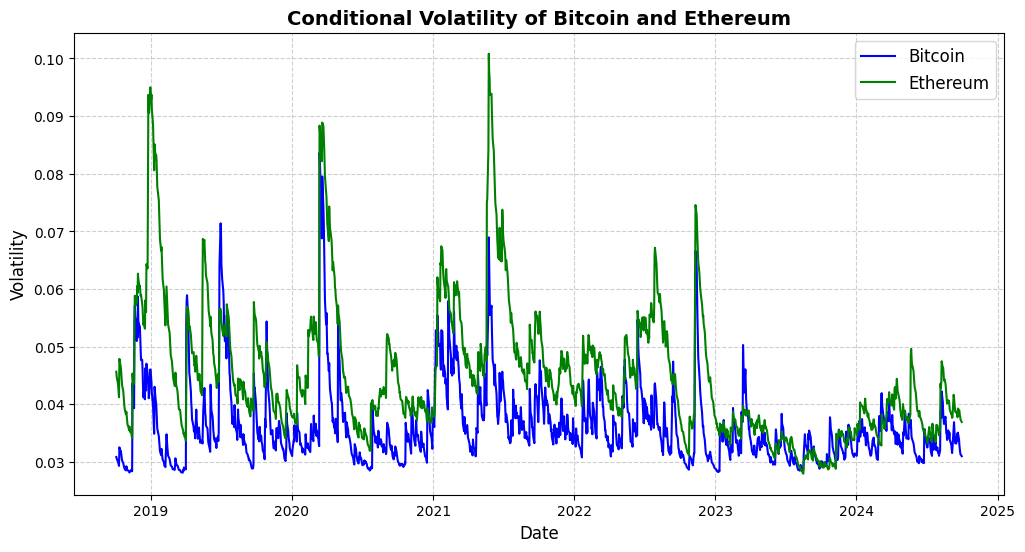

In [ ]:
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt

# Modify the function to return the GARCH model results
def run_ols_garch(asset):
    print(f"\n\n********** {asset} Model **********")

    # Add the lagged return of the specific asset
    independent_vars_with_lag = [f"{asset}_Lagged"] + independent_vars

    # Prepare the OLS model
    X = returns_df[independent_vars_with_lag]
    X = sm.add_constant(X)  # Add intercept term
    y = returns_df[asset]

    # Fit OLS Model
    ols_model = sm.OLS(y, X).fit()
    print("\nOLS Regression Results:")
    print(ols_model.summary())

    # Fit GARCH(1,1) Model
    garch_model = arch_model(
        returns_df[asset].dropna(),
        vol='Garch',
        p=1, q=1,  # Standard GARCH(1,1) specification
        mean='Constant',
        x=returns_df[["Announcement"]],  # Include FOMC announcement as exogenous variance factor
        dist='Normal'  # Assuming normal error distribution
    )

    garch_result = garch_model.fit(disp="off")

    print("\nGARCH(1,1) Model Results:")
    print(garch_result.summary())

    return garch_result  # ✅ Return the fitted GARCH model

# Run GARCH models and store results
btc_garch_result = run_ols_garch("BTC")
eth_garch_result = run_ols_garch("ETH")

# Extract conditional volatility time series
btc_volatility = btc_garch_result.conditional_volatility
eth_volatility = eth_garch_result.conditional_volatility

# ✅ Plot Conditional Volatility for BTC & ETH
plt.figure(figsize=(12, 6))
plt.plot(btc_volatility.index, btc_volatility, label="Bitcoin", color="blue", linewidth=1.5)
plt.plot(eth_volatility.index, eth_volatility, label="Ethereum", color="green", linewidth=1.5)

# Customize plot aesthetics
plt.title("Conditional Volatility of Bitcoin and Ethereum", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid for better readability
plt.show()


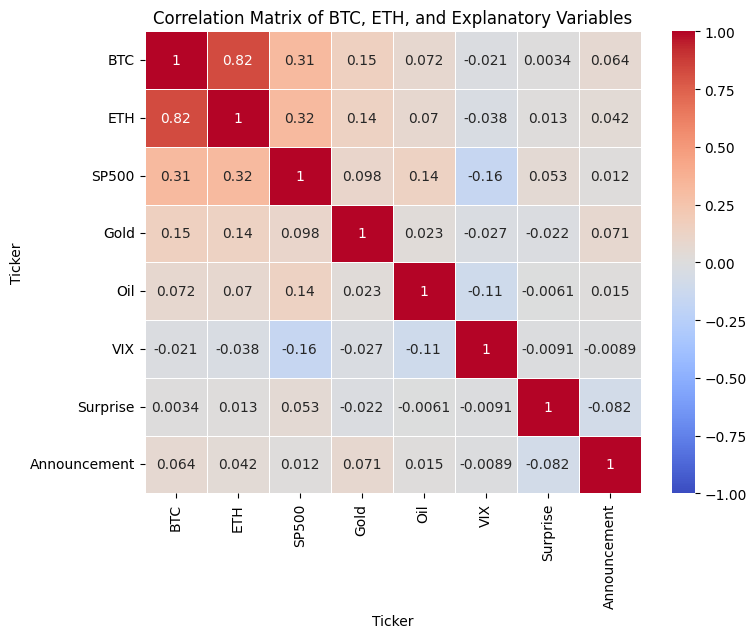

In [ ]:
# Include BTC and ETH in the correlation matrix
corr_matrix = returns_df[["BTC", "ETH", "SP500", "Gold", "Oil", "VIX", "Surprise", "Announcement", ]].corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values in each cell
    cmap="coolwarm",  # Color scheme
    center=0,  # Center the colormap at 0
    linewidths=0.5,  # Grid lines
    vmin=-1, vmax=1,  # Scale from -1 to 1
)

plt.title("Correlation Matrix of BTC, ETH, and Explanatory Variables")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.show()


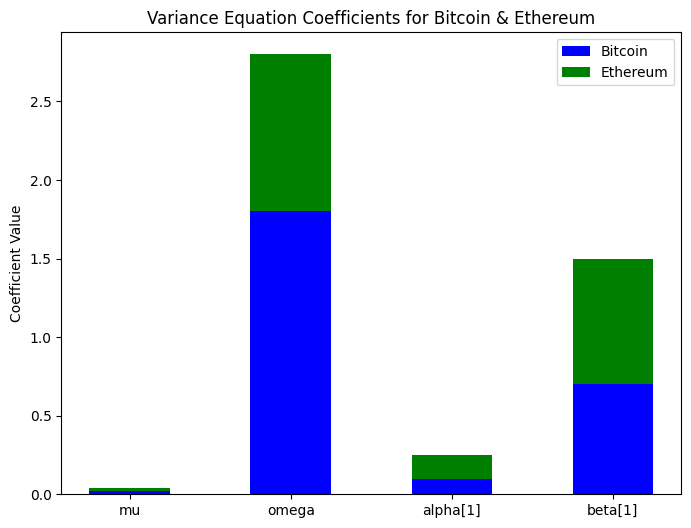

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example GARCH coefficient values (Replace with real ones from your GARCH model)
coeff_labels = ["mu", "omega", "alpha[1]", "beta[1]"]
btc_coeffs = [0.02, 1.8, 0.1, 0.7]  # Replace with BTC GARCH coefficients
eth_coeffs = [0.02, 1.0, 0.15, 0.8]  # Replace with ETH GARCH coefficients

x = np.arange(len(coeff_labels))  # X locations for groups

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
btc_bars = ax.bar(x, btc_coeffs, width=0.5, label="Bitcoin", color="blue")
eth_bars = ax.bar(x, eth_coeffs, width=0.5, bottom=btc_coeffs, label="Ethereum", color="green")

# Labels & Formatting
ax.set_xticks(x)
ax.set_xticklabels(coeff_labels)
ax.set_ylabel("Coefficient Value")
ax.set_title("Variance Equation Coefficients for Bitcoin & Ethereum")
ax.legend()

plt.show()


In [ ]:
import statsmodels.api as sm
from arch import arch_model

# Define periods
periods = {
    "Full": ("2018-01-01", "2024-09-30"),
    "Pre-COVID": ("2018-01-01", "2020-02-29"),
    "COVID": ("2020-03-01", "2021-12-31"),
    "Post-COVID": ("2022-01-01", "2024-09-30"),
}

# Create lagged return variables for BTC and ETH
returns_df["BTC_Lagged"] = returns_df["BTC"].shift(1)
returns_df["ETH_Lagged"] = returns_df["ETH"].shift(1)

# Drop NaN values caused by the lag
returns_df = returns_df.dropna()

# Define independent variables (Mean Equation)
independent_vars = [
    "SP500",  # Stock market index
    "Gold",   # Gold price changes
    "Oil",    # Crude oil price changes
    "VIX",    # Market volatility index
    "Announcement",  # FOMC event dummy (1 on announcement days, 0 otherwise)
    "Surprise",      # Interest rate surprise component
]

# Function to run OLS and GARCH models for a specific period and asset
def run_ols_garch(asset, period_name, start_date, end_date):
    print(f"\n\n********** {asset} Model - {period_name} Period ({start_date} to {end_date}) **********")

    # Filter dataset for the given period
    period_df = returns_df.loc[start_date:end_date].copy()

    # Skip if no data available
    if period_df.empty:
        print(f"⚠ No data available for {period_name} period.")
        return

    # Add the lagged return of the specific asset
    independent_vars_with_lag = [f"{asset}_Lagged"] + independent_vars

    # Prepare the OLS model
    X = period_df[independent_vars_with_lag]
    X = sm.add_constant(X)  # Add intercept term
    y = period_df[asset]

    # Fit OLS Model
    ols_model = sm.OLS(y, X).fit()
    print("\nOLS Regression Results:")
    print(ols_model.summary())

    # Fit GARCH(1,1) Model
    garch_model = arch_model(
        period_df[asset].dropna(),
        vol='Garch',
        p=1, q=1,  # Standard GARCH(1,1) specification
        mean='Constant',
        x=period_df[["Announcement"]],  # Include FOMC announcement as exogenous variance factor
        dist='Normal'  # Assuming normal error distribution
    )

    garch_result = garch_model.fit(disp="off")

    print("\nGARCH(1,1) Model Results:")
    print(garch_result.summary())

# Run models for each period and asset
for period_name, (start_date, end_date) in periods.items():
    run_ols_garch("BTC", period_name, start_date, end_date)
    run_ols_garch("ETH", period_name, start_date, end_date)




********** BTC Model - Full Period (2018-01-01 to 2024-09-30) **********

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     28.48
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           5.24e-37
Time:                        09:55:27   Log-Likelihood:                 2916.0
No. Observations:                1503   AIC:                            -5816.
Df Residuals:                    1495   BIC:                            -5774.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: Ru


                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.199
Date:                Sun, 16 Feb 2025   Prob (F-statistic):              0.306
Time:                        09:55:27   Log-Likelihood:                 646.52
No. Observations:                 349   AIC:                            -1279.
Df Residuals:                     342   BIC:                            -1252.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0078      0.009      0.866  

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002743. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001786. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled



********** ETH Model - COVID Period (2020-03-01 to 2021-12-31) **********

OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     10.55
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           2.54e-12
Time:                        09:55:27   Log-Likelihood:                 740.30
No. Observations:                 465   AIC:                            -1465.
Df Residuals:                     457   BIC:                            -1431.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001029. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


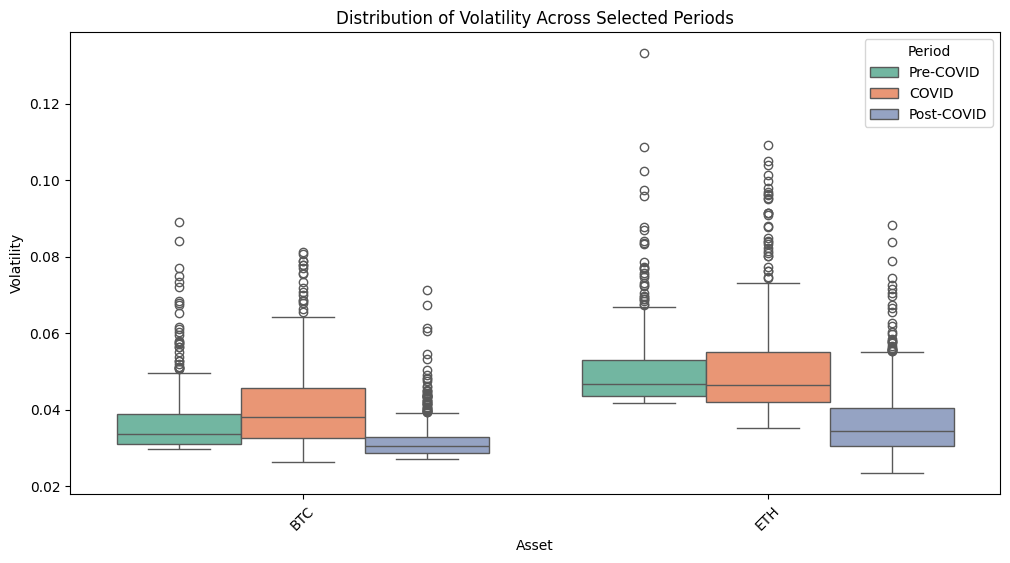

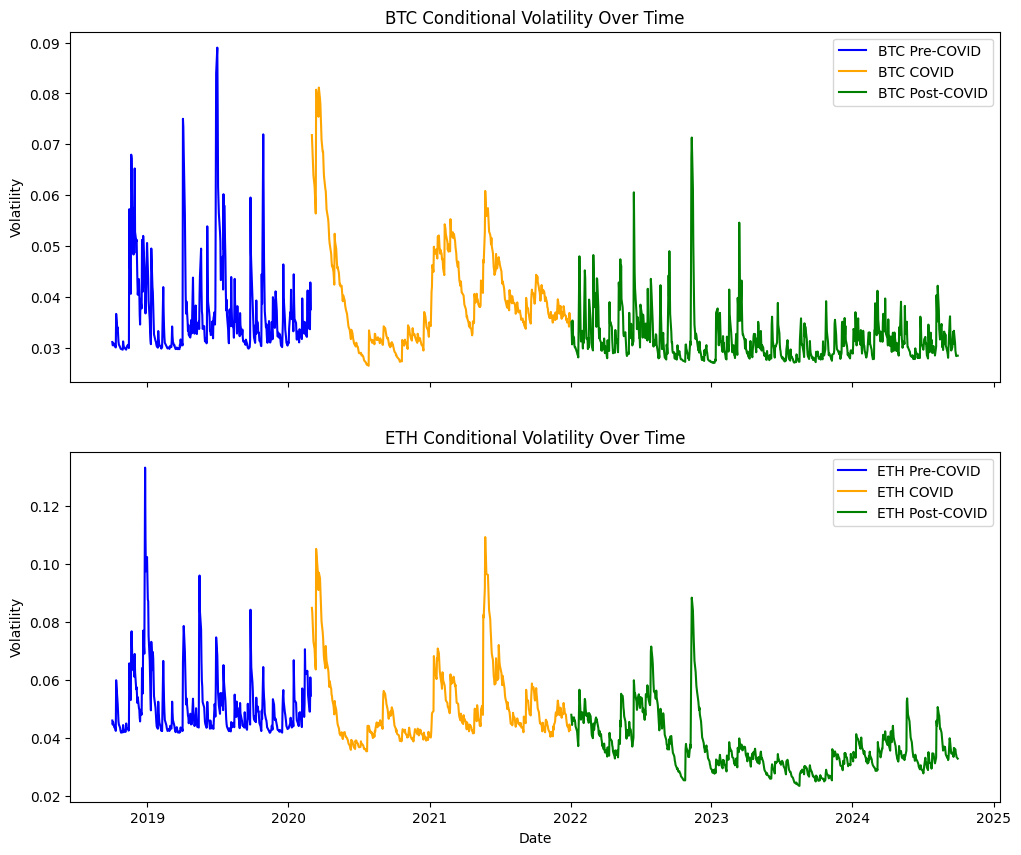

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select periods to visualize (excluding Full Period)
selected_periods = ["Pre-COVID", "COVID", "Post-COVID"]

# Dictionary to store volatility results
volatility_dict = {"BTC": {}, "ETH": {}}

# Extract conditional volatility from GARCH model for selected periods
for period_name, (start_date, end_date) in periods.items():
    if period_name in selected_periods:
        for asset in ["BTC", "ETH"]:
            period_df = returns_df.loc[start_date:end_date].copy()
            if not period_df.empty:
                # Rescale y (returns) to improve model stability
                scaled_returns = period_df[asset] * 10  # Multiply by 10

                # Fit GARCH model
                garch_model = arch_model(
                    scaled_returns.dropna(),
                    vol='Garch',
                    p=1, q=1,
                    mean='Constant',
                    x=period_df[["Announcement"]],
                    dist='Normal'
                )
                garch_result = garch_model.fit(disp="off")

                # Store volatility (conditional standard deviation)
                volatility_dict[asset][period_name] = pd.Series(
                    garch_result.conditional_volatility / 10,  # Scale back the volatility
                    index=period_df.index
                )

# Create a DataFrame for visualization
volatility_data = []
for period in selected_periods:  # Only include selected periods
    for asset in ["BTC", "ETH"]:
        volatility_data.extend([(period, asset, vol) for vol in volatility_dict[asset][period]])

volatility_df = pd.DataFrame(volatility_data, columns=["Period", "Asset", "Volatility"])

# 1️⃣ Boxplot of Volatility Across Selected Periods
plt.figure(figsize=(12, 6))
sns.boxplot(x="Asset", y="Volatility", hue="Period", data=volatility_df, palette="Set2")
plt.xticks(rotation=45)
plt.ylabel("Volatility")
plt.title("Distribution of Volatility Across Selected Periods")
plt.legend(title="Period")
plt.show()

# 2️⃣ Time Series of Conditional Volatility (Only Selected Periods)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# BTC Conditional Volatility
for period, color in zip(selected_periods, ["blue", "orange", "green"]):  # Only three colors
    axes[0].plot(volatility_dict["BTC"][period].index, volatility_dict["BTC"][period], label=f'BTC {period}', color=color)

axes[0].set_title("BTC Conditional Volatility Over Time")
axes[0].set_ylabel("Volatility")
axes[0].legend()

# ETH Conditional Volatility
for period, color in zip(selected_periods, ["blue", "orange", "green"]):  # Only three colors
    axes[1].plot(volatility_dict["ETH"][period].index, volatility_dict["ETH"][period], label=f'ETH {period}', color=color)

axes[1].set_title("ETH Conditional Volatility Over Time")
axes[1].set_ylabel("Volatility")
axes[1].legend()

plt.xlabel("Date")
plt.show()
